In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_log_error, r2_score, explained_variance_score

In [3]:
directorio_base = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Subir dos directorios
directorio_pkl = os.path.join(directorio_base, "src", "00.data", "clustering")

# Obtener todos los archivos .pkl en el directorio de preprocesado
archivos_pkl = [f for f in os.listdir(directorio_pkl) if f.startswith("df_clustering_") and f.endswith(".pkl")]

# Si no se encuentran archivos .pkl, mostramos un mensaje
if not archivos_pkl:
    print("❌ No se encontraron archivos .pkl en el directorio.")
else:
    df_lista = []

    # Cargar todos los archivos .pkl
    for archivo in archivos_pkl:
        ruta_archivo = os.path.join(directorio_pkl, archivo)
        try:
            with open(ruta_archivo, "rb") as f:
                df_lista.append(pickle.load(f))
                print(f"✅ Archivo cargado correctamente: {archivo}")
        except FileNotFoundError:
            print(f"❌ No se encontró el archivo: {archivo}")
        except Exception as e:
            print(f"❌ Error al cargar {archivo}: {e}")

    # Concatenar todos los DataFrames en uno solo
    if df_lista:
        df = pd.concat(df_lista, ignore_index=True)
        print(f"✅ DataFrame final con {df.shape[0]} filas y {df.shape[1]} columnas")
    else:
        print("❌ No se cargaron DataFrames.")

✅ Archivo cargado correctamente: df_clustering_1.pkl
✅ Archivo cargado correctamente: df_clustering_2.pkl
✅ Archivo cargado correctamente: df_clustering_3.pkl
✅ DataFrame final con 207137 filas y 10 columnas


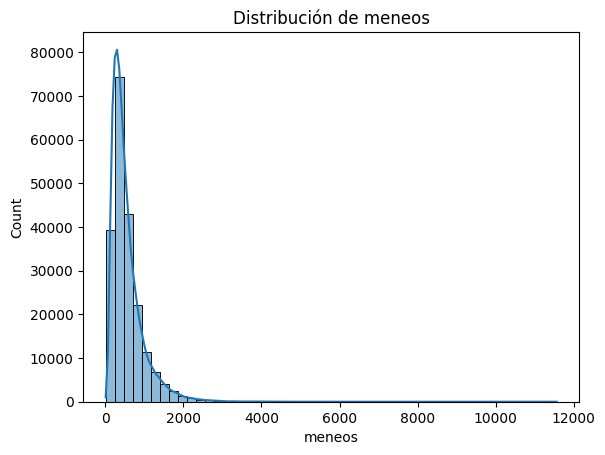

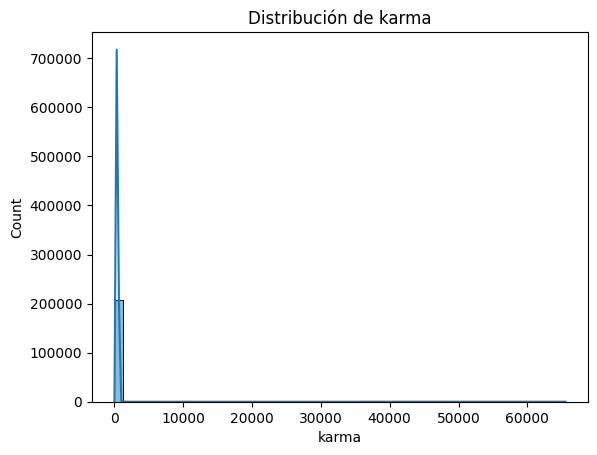

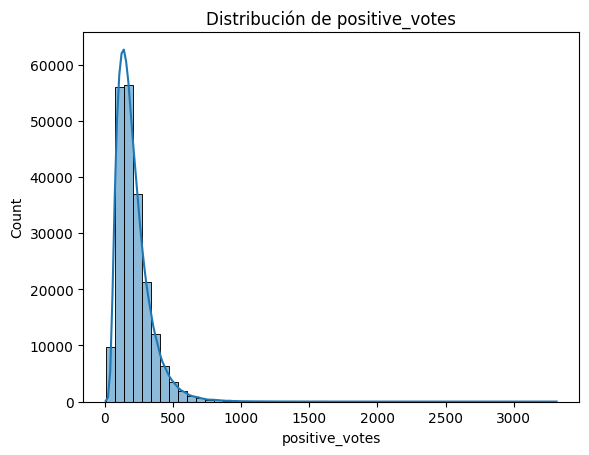

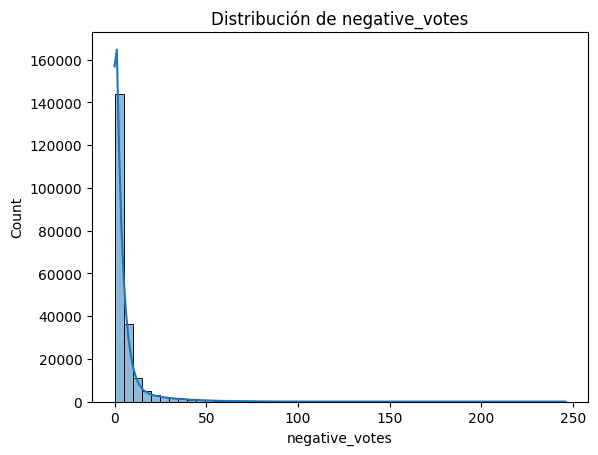

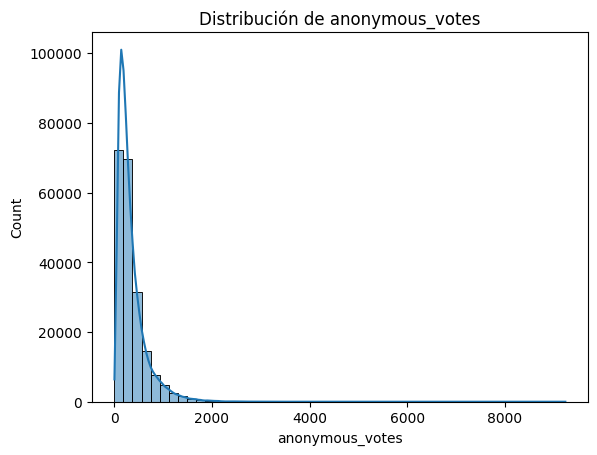

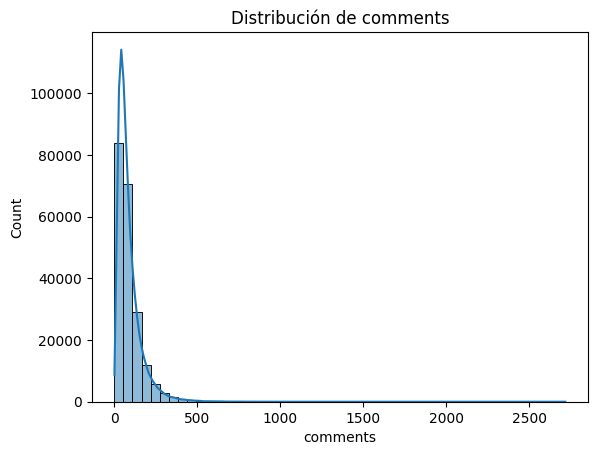

In [4]:
# Gráficoss para ver la distribución de variables numéricas y saber si aplicar nplog1
for col in ['meneos', 'karma', 'positive_votes', 'negative_votes', 'anonymous_votes', 'comments']:
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

In [ ]:
# Definir Variables
num_features = ['meneos', 'karma', 'positive_votes', 'anonymous_votes', 'negative_votes', 'comments']
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Rutas de almacenamiento
BASE_DIR = "../00.data/clustering"
os.makedirs(BASE_DIR, exist_ok=True)
scaler_path = os.path.join(BASE_DIR, "regressor_scaler.pkl")
encoder_path = os.path.join(BASE_DIR, "regressor_encoder.pkl")

# Aplicar transformación log1p antes del escalado
df[num_features + ['clicks']] = np.log1p(df[num_features + ['clicks']])
df[num_features] = df[num_features].astype('float32')

In [ ]:
# Normalizar con un único scaler (antes de dividir por clusters)
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Guardar scaler
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f, protocol=pickle.HIGHEST_PROTOCOL)

# OneHotEncoding con un único encoder (antes de dividir por clusters)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[['category']])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(['category']))

# Guardar encoder
with open(encoder_path, "wb") as f:
    pickle.dump(encoder, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Unir categorías codificadas
df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)
df = pd.concat([df, encoded_df], axis=1).drop(columns=['category'])

# Obtener clusters únicos
clusters = df['cluster'].unique()
all_metrics = []

# Procesar cada cluster
for cluster in clusters:
    print(f'📊 Procesando cluster {cluster}...')

    df_cluster = df[df['cluster'] == cluster].drop(columns=['cluster', 'news_id']).copy()
    print(f"Tamaño original del cluster {cluster}: {df_cluster.shape}")

    # Remover outliers solo dentro del cluster
    def remove_outliers_tukey(df, columns):
        Q1 = df[columns].quantile(0.25)
        Q3 = df[columns].quantile(0.75)
        IQR = Q3 - Q1
        df_filtered = df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
        return df_filtered

    df_cluster = remove_outliers_tukey(df_cluster, num_features)
    print(f"Tamaño después de eliminar outliers: {df_cluster.shape}")

    # Función de entrenamiento y evaluación (dentro del bucle)
    def train_and_evaluate_model(X_train, X_test, y_train, y_test, model, model_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 📌 9.4.1 Aplicar la función inversa expm1
        y_pred_original = np.expm1(y_pred)
        y_test_original = np.expm1(y_test)

        metrics = {
            "Model": model_name,
            "MAE": mean_absolute_error(y_test_original, y_pred_original),
            "Median AE": median_absolute_error(y_test_original, y_pred_original),
            "R²": r2_score(y_test_original, y_pred_original)
        }

        return metrics, model

    # Definir X y y
    X = df_cluster.drop(columns=['clicks']).astype('float32')
    y = df_cluster['clicks']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calcular correlación y graficar
    correlation_with_clicks = df_cluster.corr()['clicks'].drop('clicks').abs().sort_values(ascending=False)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_with_clicks.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.title(f'Correlación de Variables con Clicks - Cluster {cluster}')
    plt.show()

    # Entrenar y evaluar modelos
    best_model = None
    best_medae = float('inf')

    for model_name, model in models.items():
        metrics, trained_model = train_and_evaluate_model(X_train, X_test, y_train, y_test, model, model_name)
        metrics['Cluster'] = cluster
        all_metrics.append(metrics)

        # Guardar el mejor modelo basado en Median AE
        if metrics['Median AE'] < best_medae:
            best_medae = metrics['Median AE']
            best_model = trained_model

    # Guardar el mejor modelo del cluster
    ml_regression_path = os.path.join(BASE_DIR, f"ml_regression_cluster_{cluster}.pkl")
    with open(ml_regression_path, "wb") as f:
        pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Proceso completado con éxito.")

In [8]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df

,Model,Median AE,MAE,MSLE,R2,Explained Variance,Cluster
0,Linear Regression,1414.101318,2476.128662,0.614748,0.155921,0.224088,0
1,Random Forest,1352.176872,2373.057740,0.589790,0.242299,0.291862,0
2,Gradient Boosting,1329.791855,2384.672007,0.576088,0.209199,0.272008,0
3,Linear Regression,2118.844727,3440.467773,0.556456,0.113759,0.169308,1
4,Random Forest,2141.011413,3373.434325,0.548774,0.168656,0.217067,1
5,Gradient Boosting,2069.233964,3387.120629,0.532900,0.126796,0.182523,1
6,Linear Regression,1471.586060,2568.460205,0.442445,0.150965,0.193583,2
7,Random Forest,1471.340499,2574.146689,0.454865,0.164050,0.199516,2
8,Gradient Boosting,1439.710430,2514.329318,0.428864,0.181061,0.224201,2


In [ ]:
# Parece que en general todos los modelos explican poco la variabilidad de clicks debido a la baja R²
# Es posible que esto sea por variables que no hemos tenido en cuenta durante la creación del modelo, como la hora, día, semana, mes de publicación, source, etc...
# El Median AE y MAE son altos en cualquier todos los modelos
# Gradient Boosting Regressor parece el mejor modelo en todos los casos

# Analizando por cluster, el Cluster 1 (Noticias estándar) parece el más fácil de predecir con errores más bajos y R² más alto
# Cluster 0 (Noticias polémicas o virales con gran interacción), tiene el mayor Median AE y MAE de todos los clusters.
# Las noticias virales o polémicas tienen un comportamiento atípico dentro del dataset por definición
# Cluster 2 (Noticias bien recibidas) tiene errores intermedios entre Cluster 0 y 1

# En próximos pasos se debería estudiar hacer otros modelos como Redes Neuronales, e incorporar variables nuevas, así como probar Feature engineering